# Assignment 4: Seq2seq
_Word Representations and Language Models (WS 24/25)_

Group Members: Buket Sak, Ludmila Bajuk, Alexander Weyhe
***

In this week's assignment, you will learn how to train a sequence-to-sequence model for translating text from German into English. First, you will train a custom LSTM model from scratch using a parallel corpus. Next, you will evaluate the model by comparing the prediction with the correct translation. Finally, you will compare your LSTM model with a state-of-the-art transformer-based model.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#FFF2CC;border-color:#D6B656;color:#856404">
<b>How to Submit the Assignment</b>

Please work on this assignment in groups of two or three. Make sure to add your names to this files' header. After completion, share this assignment with me (<b>Julian Schelb - <a target="blank" href="https://www.kaggle.com/julianschelb">https://www.kaggle.com/julianschelb</a></b>) due Wednesday, 27th November, 12:00. Use the upper-right share button as instructed in the tutorial. In ILIAS, submit this notebook as response to Assignment 4. You can download this notebook using the "Download Notebook" option in the "File" menu.
</div>

In [3]:
from sklearn.model_selection import train_test_split
from nltk.metrics import edit_distance 
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import json

import torch
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

## Task 1: Load and Preprocess Dataset

Sequence-to-Sequence (seq2seq) models can be used in various NLP tasks, including entity recognition and text summarization. In this assignment, neural machine translation is the main topic, where sentences serve as both the input and the output. 

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Dataset</b> 
</div>

Fist, you need to obtain some training data from [manythings.org/anki/](http://www.manythings.org/anki/). This website provides datasets for various languages, which we will use to train our model for translating text into English. We ask you to complete the following steps:

1. Choose one of the datasets containing sentence pairs. In general, you can pick any language, but you may encounter unique problems with some of them. If you want to play it safe, use the [German](http://www.manythings.org/anki/deu-eng.zip) variant. You also want to choose a language with at least a few thousand sentence pairs available. Download the .zip file in the language you would like to work with.
2. Next, create a dataset on kaggle. This allows us to access the dataset more conveniently. We suggest using the "Upload Data" Option in the data section on the right-hand side. 
3. Read the text file containing the sentence pairs. Notice that the text file is tab delimited.
4. Print the first five rows of your dataset.


_(Hint: To keep training times manageable, consider starting with a subset of 50,000 sentence pairs before scaling up to the full dataset of 250,000 sentences, as training on the entire dataset may take some time.)_

In [4]:
# Function which reads txt file and returns a dataframe
def read_txt(file):
    return pd.read_csv(file, sep="\t", header=None, names=["English", "German", "ID"])

# Read txt file
df = read_txt("/kaggle/input/deu-eng/deu.txt")

df.head()

,English,German,ID
0,Go.,Geh.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Hallo!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Grüß Gott!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run.,Lauf!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [ ]:
# OPTIONAL: Limit the size of the training corpus

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Preprocessing</b> 
</div>

Now that you have imported the dataset, we ask you to perform a series of preprocessing steps. Those will make training easier.

1. Remove the unnecessary third column containing licence information from the data set.
2. Transform both sentences into lower case.


In [5]:
# Drop unnecessary column.
df = df.drop(columns=["ID"])

# Transform sentences into lower case
for column in ["English", "German"]:
    df[column] = df[column].str.lower()

df.head()

,English,German
0,go.,geh.
1,hi.,hallo!
2,hi.,grüß gott!
3,run!,lauf!
4,run.,lauf!


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Encode & Decode Text Sequences</b> 
</div>

A Seq2Seq model requires that we convert the input and output into integer sequences of a fixed length. To achieve this, we can use the [Tokenizer](https://pytorch.org/text/stable/data_utils.html#torchtext.data.utils.get_tokenizer) provided by PyTorch. We ask you to implement the following steps:

1. Calculate the maximum sequence length (number of tokens) for both languages (i.e. the longest sentence). You will need this information later to pad the input sequence.
2. Implement a vocabulary class that can be used to encode an input sequence and decode the output sequence for both languages in your training corpus. You can make use of PyTorch features, e.g. the [get_tokenizer()](https://pytorch.org/text/stable/data_utils.html#torchtext.data.utils.get_tokenizer) method, and build the corresponding vocabularies with the [build_vocab_from_iterator()](https://pytorch.org/text/stable/vocab.html#build-vocab-from-iterator) method. Print the sizes of the resulting vocabulary.
3. Implement a function `encodeSequence()` that uses the tokenizers to encode the sentences in your corpus to vectors, which we can feed into the model for training. Note that you also need to pad the sequence to the maximal length occurring for each language. This is where the maximum sequence lengths are helpful. [Consider this example](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html#data-processing).
4. Implement a function `decodeSquence()` that converts the vectors back to text. We will use the function later to compare the predictions of our model to the correct translations.
5. Test your functions by first encoding a German and English sentence and then decoding the token ID vector back into textual form. You can source your example from the dataset or get creative by coming up with  your own example sentence.


In [6]:
## Complete this vocabulary class

class Vocabulary:
    def __init__(self, language, sentences):
        """Initialize the Vocabulary class."""
        self.language = language
        self.sentences = sentences
        self.tokenizer = get_tokenizer("basic_english")
        self.build_vocabulary()

    def build_vocabulary(self):
        """Build the vocabulary and mappings."""
        def yield_tokens(data):
            for sentence in data:
                yield self.tokenizer(sentence)

        self.vocab = build_vocab_from_iterator(yield_tokens(self.sentences), specials=["<unk>", "<sos>", "<eos>", "<pad>"])
        self.vocab.set_default_index(self.vocab["<unk>"])

        print(f"Vocabulary size after filtering: {len(self.vocab)}")
        return self.vocab
        
    # Function to convert sentences to vectors
    def encodeSequence(self, max_length, sent):
        """Tokenize a sentence, convert tokens to IDs, and pad the sequence."""
        tokens = self.tokenizer(sent) 
        sequence = [self.vocab[token] for token in self.tokenizer(sent)]

        if len(sequence) < max_length:
            # determine how many tokens are missing
            padding_term = [self.vocab["<pad>"]] * (max_length - len(sequence))

            return [self.vocab["<sos>"]] + sequence + [self.vocab["<eos>"]] + padding_term
        
        else:
            return [self.vocab["<sos>"]] + sequence + [self.vocab["<eos>"]]
            
    # Function to convert vectors to sentences
    def decodeSequence(self, sequence):
        """Converts a list of token IDs to text."""
        tokens = [self.vocab.lookup_token(idx) for idx in sequence if idx not in {self.vocab["<pad>"], self.vocab["<sos>"], self.vocab["<eos>"]}]
        return " ".join(tokens)
        
    def __len__(self):
        """Return the vocabulary size."""
        return len(self.vocab)

In [7]:
# Build Tokenizer for your source language
vocab_en = Vocabulary("English", list(df["English"]))

# Build Tokenizer your target language
vocab_de = Vocabulary("German", list(df["German"]))

Vocabulary size after filtering: 17946
Vocabulary size after filtering: 39489


In [8]:
# Find maximum length for english languages
max_length_en = max(len(vocab_en.tokenizer(sent)) for sent in df["English"])
print(f"Max lenght in English: {max_length_en}")

# Find maximum length for german languages
max_length_ger = max(len(vocab_en.tokenizer(sent)) for sent in df["German"])
print(f"Max lenght in German: {max_length_ger}")

Max lenght in English: 110
Max lenght in German: 89


Now we can convert the text into numeric values, i.e. tokenize the data. This lets the neural network work with the input data. When we run the tokenizer, it creates a vocabulary which is used to convert each sentence into a vector. When we feed our sequences of word IDs into the model, each sequence must be the same length. To achieve this, a padding is added to each sequence that is shorter than the maximum length.

In [9]:
# Example sentences to test ("abc" to simulate unknown token)
example = "I saw a cat abcd in the park!"

# Encode the sentences using the previously defined function
example_encoded = vocab_en.encodeSequence(max_length_en, example)

# Print the encoded sequence
print("Sentence encoded as vector constructed out of word IDs:\n" + str(example_encoded))

Sentence encoded as vector constructed out of word IDs:
[1, 6, 207, 12, 402, 0, 20, 10, 417, 183, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [10]:
# Decode the sentences using the previously defined function
example_decoded =  vocab_en.decodeSequence(example_encoded)

# Print the encoded sequence
print("Token IDs decoded:\n" + str(example_decoded))

Token IDs decoded:
i saw a cat <unk> in the park !


In [11]:
# Example sentences to test 
examples = "Ich sah eine Katze im Park!"

# Encode the sentences using the previously defined function
test_sequence = vocab_de.encodeSequence(max_length_ger, examples)

# Print the encoded sequence
print("Sentence encoded as vector constructed out of word IDs:\n" + str(test_sequence))

Sentence encoded as vector constructed out of word IDs:
[1, 6, 224, 34, 417, 58, 607, 26, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


<b>Step 3: Split Corpus into Training- and Test-Datasets</b> 
</div>

As the final preprocessing step, we ask you to split the dataset into a training and test set before encoding them separately using the function we defined earlier. Please complete the following tasks:

1. Obtain a train and test dataset by splitting the corpus. The training dataset should contain roughly 80% of all sentences. You may want to restrict your test dataset even further due to memory restrictions. 
2. Encode all sentences using the tokenizers you created earlier. Also, don't forget to pad the input and output sequence.

In [12]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df["German"], df["English"], test_size=0.2, random_state=42)

We will use German and English sentences as the input and target sequence. But first we need to encode both sentences. This is needed for both the training and test datasets.

In [13]:
# Encode sequences in training data
X_train_encode = [vocab_de.encodeSequence(max_length_ger, data) for data in X_train]
y_train_encode = [vocab_en.encodeSequence(max_length_en, data) for data in y_train]

# Encode sequences in test data
X_test_encode = [vocab_de.encodeSequence(max_length_ger, data) for data in X_test]
y_test_encode = [vocab_en.encodeSequence(max_length_en, data) for data in y_test]

## Task 2: Train Seq2seq Model

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Define the Model</b> 
</div>

Since the data is now in the correct format, we can proceed with training a LSTM model. Below is a model definition that you can use. It is totally fine to use this simple model architecture, but feel free to optimize the architecture or come up with your own. Here are some ideas: you could increase the number of parameters, add layers, change the learning rate, etc. Here are some resources you can use as inspiration.

Some Code Examples:

* [Translation With a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
* [Sequence to Sequence Learning with Neural Networks](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)

Documentation:

- [Dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
- [Dense layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [LSTM layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)
- [GRU layer](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.dynamic.GRU.html)
- [Softmax layer](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
- [Optimizers](https://pytorch.org/docs/stable/optim.html)

In [14]:
# Parameters
in_vocab = len(vocab_de.vocab) # deu_vocab_size # German vocab size [YOU NEED TO CHANGE THIS]
out_vocab = len(vocab_en.vocab) # eng_vocab_size # English vocab size [YOU NEED TO CHANGE THIS]
in_timesteps = max_length_ger + 2 # max_length_de # Length of the input sequence  [YOU NEED TO CHANGE THIS]
out_timesteps = max_length_en + 2  # max_length_en # Length of the output sequence [YOU NEED TO CHANGE THIS]
units = 512 # Number of neurons
learning_rate = 0.0005 # Learning rate

In [15]:
## Model definition

import torch
import torch.nn as nn
import torch.optim as optim

class Seq2SeqModel(nn.Module):
    def __init__(self, in_vocab, out_vocab, units, in_timesteps, out_timesteps):
        super(Seq2SeqModel, self).__init__()
        self.in_timesteps = in_timesteps
        self.out_timesteps = out_timesteps
        self.units = units
        self.embedding = nn.Embedding(in_vocab, units, padding_idx=0)
        self.lstm1 = nn.LSTM(units, units, batch_first=True)
        self.lstm2 = nn.LSTM(units, units, batch_first=True)
        self.dense = nn.Linear(units, out_vocab)

    def forward(self, x):
        x = self.embedding(x)
        x = x.flip(1)  # Reverse the input sequence
        x, _ = self.lstm1(x)

        # Replicate the last output for the output sequence length
        x = x[:, -1, :].unsqueeze(1).repeat(1, self.out_timesteps, 1)
        
        x, _ = self.lstm2(x)
        x = self.dense(x)
        return x

In [16]:
# Model instantiation
model = Seq2SeqModel(in_vocab, out_vocab, units, in_timesteps, out_timesteps)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define loss function
loss_function = nn.CrossEntropyLoss(ignore_index=0) 

In [17]:
print("Model Architecture:", model)

Model Architecture: Seq2SeqModel(
  (embedding): Embedding(39489, 512, padding_idx=0)
  (lstm1): LSTM(512, 512, batch_first=True)
  (lstm2): LSTM(512, 512, batch_first=True)
  (dense): Linear(in_features=512, out_features=17946, bias=True)
)


svg image

**Briefly answer the following questions:**

1. Describe the implementation of the encoder and decoder components and explain how the model's architecture corresponds to the abstract Seq2Seq architecture depicted in the preceding figure.
2. We reverse the input sequence with `x = x.flip(1)`. Can you explain the intuition behind reversing the input sequence? _(Hint: The authors of this week's paper mention possible interpretations.)_

Taks 1: We input each batch into the embedding layer of size of our maximum length of the German sentences. The embdeddings are then input to the first LSTM layer which represents the encoder. Before that, we reverse each input sequence. The ouput is replicated and repeatedly input to the second LSTM layer (decoder) at each time step. The final dense layer maps the 2nd LSTM ouputs to the English vocabulary size and representing probabilities for each word in the English vocabulary.

Task 2: By reversing the input sequence, we can establish many short term dependencies.  

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Train the Model</b> 
</div>

To train the model, you need to implement a training loop [similar to this implementation](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb). Train the model for 20 epochs. Make sure to store the training history. Depending on the size of your training corpus, this will take some time. For the German to English dataset, training will take about 60 min **with GPU acceleration enabled.**

**Useful Resources:**
* [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
* [Dataset or TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
* [How to Accelerate Training using PyTorch with CUDA](https://cnvrg.io/pytorch-cuda/)
* [Connection between loss.backward() and optimizer.step()](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step)

**Tutorials:**
* [Translation With a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
* [Sequence to Sequence Learning with Neural Networks](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)


In [18]:
# Training Parameters
batch_size = 192  # You can adjust this
epochs = 20  # You can adjust this

**Split into train and validation set:**

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_encode, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_encode, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_encode, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encode, dtype=torch.long)

# Step 2: Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the proportion for the validation set (e.g., 80% train, 20% validation)
validation_split = 0.2
train_size = int((1 - validation_split) * len(train_dataset))
val_size = len(train_dataset) - train_size

# Use random_split to split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Push the mdoel to the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

**Functions for training and validation:**

In [21]:
import torch
from tqdm import tqdm

def trainModel(model, device, train_loader, optimizer, loss_function, epoch, epochs):
    """Train the model for one epoch."""
    model.train()
    epoch_loss = 0
    for batch, (source, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False)):
        source = source.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(source)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        
        target = target[1:].view(-1)
        
        loss = loss_function(output, target)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)



def validateModel(model, device, val_loader, loss_function):
    """Evaluate the model."""
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for batch, (source, target) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch + 1}", leave=False)):
            source = source.to(device)
            target = target.to(device)

            output = model(source)

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            
            target = target[1:].view(-1)
            
            loss = loss_function(output, target)
        
            epoch_loss += loss.item()
    
    return epoch_loss / len(val_loader)

**Training for multiple epochs:**

In [23]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Lists to store loss values
loss_values = []  
loss_values_val = []

# Training Loop with GPU support
for epoch in range(epochs):

    # Training
    avg_loss = trainModel(model, device, train_loader, optimizer, loss_function, epoch, epochs)
    loss_values.append(avg_loss)
    print(f'Training Loss: {avg_loss:.4f}')

    # Validation
    avg_val_loss = validateModel(model, device, val_loader, loss_function)
    loss_values_val.append(avg_val_loss)
    print(f'Validation Loss: {avg_val_loss:.4f}')

# Save your model after training
torch.save(model.state_dict(), 'seq2seq_model.pth')

Training Loss: 0.4512


Validation Loss: 0.4052


Training Loss: 0.3848


Validation Loss: 0.3775


Training Loss: 0.3522


Validation Loss: 0.3426


Training Loss: 0.3240


Validation Loss: 0.3162


Training Loss: 0.2964


Validation Loss: 0.2948


Training Loss: 0.2708


Validation Loss: 0.2754


Training Loss: 0.2484


Validation Loss: 0.2595


Training Loss: 0.2287


Validation Loss: 0.2502


Training Loss: 0.2114


Validation Loss: 0.2395


Training Loss: 0.1963


Validation Loss: 0.2352


Training Loss: 0.1828


Validation Loss: 0.2311


Training Loss: 0.1707


Validation Loss: 0.2285


Training Loss: 0.1597


Validation Loss: 0.2289


Training Loss: 0.1501


Validation Loss: 0.2305


Training Loss: 0.1414


Validation Loss: 0.2296


Training Loss: 0.1338


Validation Loss: 0.2312


Training Loss: 0.1267


Validation Loss: 0.2322


Training Loss: 0.1204


Validation Loss: 0.2350


Training Loss: 0.1145


Validation Loss: 0.2381


Training Loss: 0.1090


Validation Loss: 0.2408


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Plot Training History</b> 
</div>

Plot the training and validation loss for each epoch and provide a short interpretation. Did the model learn? Is the model overfitting or underfitting?

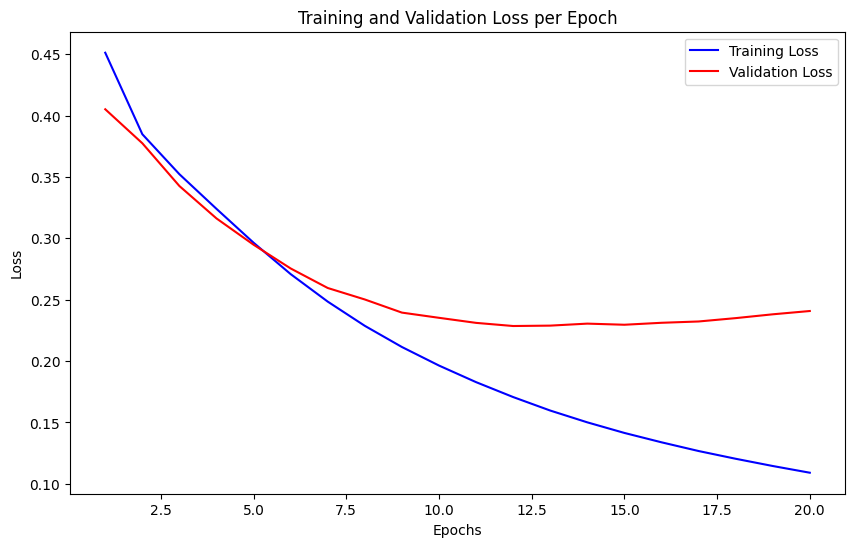

In [24]:
# Plot validation and train loss per epoch
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label="Training Loss", color='blue')
plt.plot(range(1, len(loss_values_val) + 1), loss_values_val, label="Validation Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Show the plot
plt.show()

**Interpret the training history:**
The first thing we can see is that the loss only decreases with very (very) little steps. Additionally, the loss for the validation set starts to increase again after around 13 epochs while the training loss continues to decrease. This is a strong indicator for that our model starts overfitting.

## Task 3: Evaluate Model

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Make Predictions</b> 
</div>

We can now test how good the model is at translating. We ask you to implement the following steps:

1. Use the model to translate the sentences in the test dataset. The model will return logits, which you need to convert to probabilites over the whole vocabulary for every output token a using a [softmax layer](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html).  
2. Convert the probabilities into word IDs [torch.argmax()](https://pytorch.org/docs/stable/generated/torch.argmax.html)
3. Convert the word IDs into sentences by matching them to the corresponding words using the function you implemented earlier.

In [26]:
def getPredictions(model, device, test_loader):
    """Performs predictions using the provided model on the test data."""
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in test_loader:
            # Move data to the same device as the model
            inputs = batch[0].to(device)

            # Forward pass through the model
            outputs = model(inputs)

            # Get predicted token indices
            predicted_indices = outputs.argmax(dim=-1)

            # Collect predictions
            all_predictions.extend(predicted_indices.cpu().tolist())

    return all_predictions

In [27]:
# Get predictions
decoded_predictions = [vocab_en.decodeSequence(pred) for pred in getPredictions(model, device, test_loader)]
decoded_predictions[:5]

['she left up for noon .',
 'i was just to call you .',
 'tom pretended he was listening .',
 "let ' s the the road .",
 'it is said he knows knows the secret secret']

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Compare Predictions with Label</b> 
</div>

Now compare the predictions with the correct translations:

1. Calculate the [edit distance](https://www.nltk.org/api/nltk.metrics.distance.html#nltk.metrics.distance.edit_distance) between predicted English sentence and correct translation. 
2. Calculate the [sentence BLEU score](https://www.nltk.org/api/nltk.translate.bleu_score.html#nltk.translate.bleu_score.sentence_bleu) with the correct translation as reference and the prediction as hypotheses. [Here](https://aclanthology.org/P02-1040.pdf) you can read more about the BLEU Score.
3. Calculate the mean BLEU score and mean edit distance for different input length intervals.
3. Print out the worst and the best predictions. 
4. Provide a short assessment of the translation's quality. Did the model capture the key aspects of the input sentence most of the time? 

In [28]:
# Compare prediction and label using edit distance
# List of tuples containing preiction, ground truth and edit score
edit_distances = []

# List of all edit
edit_distances_scores = []

for pred, label in zip(decoded_predictions, X_test):
    dist = edit_distance(pred, label)
    edit_distances.append((pred, label, dist))
    edit_distances_scores.append(dist)

edit_distances[:5]

[('she left up for noon .', 'sie hat sich gegen mittag blicken lassen.', 32),
 ('i was just to call you .', 'ich wollte sie gerade anrufen.', 22),
 ('tom pretended he was listening .', 'tom tat so, als hörte er zu.', 22),
 ("let ' s the the road .", 'gehen wir über die straße!', 18),
 ('it is said he knows knows the secret secret',
  'man sagt, er kenne das geheimnis.',
  32)]

In [29]:
# Best predictions
best_prediction = [0, 20]

for index, (_, _, score) in enumerate(edit_distances):
    if score < best_prediction[1]:
        best_prediction[0] = index
        best_prediction[1] = score

edit_distances[best_prediction[0]]

('tom is tolerant .', 'tom ist tolerant.', 2)

In [30]:
# Worst predictions
worst_prediction = [0, 0]

for index, (_, _, score) in enumerate(edit_distances):
    if score > best_prediction[1]:
        best_prediction[0] = index
        best_prediction[1] = score

edit_distances[best_prediction[0]]

("it ' s sorry that that is ' be be be a a , , , , , , , , , , , , , a a , , , , , , , , ,",
 'es ist wohl unmöglich, einen vollkommen fehlerfreien korpus zu erreichen\xa0— das liegt in der natur eines solchen gemeinschaftsprojekts. doch wenn wir unsere mitglieder dazu bringen können, nicht mit sprachen herumzuexperimentieren, die sie gerade lernen, sondern sätze in ihrer eigenen muttersprache beizutragen, dann gelingt es uns vielleicht, die zahl der fehler klein zu halten.',
 322)

In [32]:
# Calculate mean BLEU score and edit distance per input lengths
from nltk.translate.bleu_score import sentence_bleu
import statistics

bleu_scores = []

for pred, label in zip(decoded_predictions, X_test):
    bleu_scores.append(sentence_bleu([label], pred))

mean_bleu = statistics.mean(bleu_scores)
mean_edit_distance = statistics.mean(edit_distances_scores)

print(f"The mean bleu score is: {mean_bleu}.")
print(f"The mean edit distance score is: {mean_edit_distance}.")

The mean bleu score is: 0.2606577816327706.
The mean edit distance score is: 26.788985048309613.


 **Interpret the results:**
 In general, the results are okay but not very impressive. For short sentences, the model can produce meaningful sentences that resemble the meaning of our ground truths. However, even with short sentences, we can see that the model produces words twice. With long sentences, the model performs rather poorly by producing wrong translations and arbitrary sequences of tokens. 


## Task 4: Comparison with State-of-the-Art (OPTIONAL)


Finally, we want to compare our own model against a state-of-the-art transformer model. We recommend using the model [opus-mt-de-en](https://huggingface.co/Helsinki-NLP/opus-mt-de-en) for German to English translation. If you used a dataset with different languages, [here is a list](https://huggingface.co/Helsinki-NLP) of models trained for translating a variety of languages. We ask you to implement the following:

1. Load the pretrained model and tokenizer for the model [opus-mt-de-en](https://huggingface.co/Helsinki-NLP/opus-mt-de-en) using the transformer package.
2. Use this model to translate the source sentences in the test dataset to English (like we did with the LSTM model). [Here](https://huggingface.co/Lalita/marianmt-th-zh_cn) you can see how to obtain predictions and [here](https://huggingface.co/docs/transformers/tasks/translation) is some more documentation on how to use transformers for translation.

**Analogous to the previous step, compare the predictions with the correct translations:**

3. Calculate the [edit distance](https://www.nltk.org/api/nltk.metrics.distance.html#nltk.metrics.distance.edit_distance) between predicted English sentence and correct translation. 
4. Calculate the [sentence BLEU score](https://www.nltk.org/api/nltk.translate.bleu_score.html#nltk.translate.bleu_score.sentence_bleu) with the correct translation as reference and the prediction as hypotheses.
5. Calculate the mean BLEU score and mean edit distance.
6. Print out the worst and the best predictions. 
7. Provide a short assessment of the translation's quality. How does it perform in comparison to the LSTM model?

In [ ]:
# HINT:
#del model
#torch.cuda.empty_cache()

In [ ]:
device = "cuda"

In [ ]:
# Load pretrained tokenizer and model
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# tokenizer_trf = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")
# model_trf = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-de-en").to(device)

In [ ]:
# Use model to make prediction


In [ ]:
# Compare prediction and label using edit distance


In [ ]:
# Best predictions


In [ ]:
# Worst predictions


In [ ]:
# Calculate mean BLEU score and edit distance per input lengths


 **Interpret:**
